<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x27f9a66ffd0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

c:\Users\CSR\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\CSR\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0953 | train_acc: 0.4453 | test_loss: 0.9211 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8647 | train_acc: 0.7891 | test_loss: 0.8031 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7762 | train_acc: 0.7812 | test_loss: 0.7428 | test_acc: 0.7633
Epoch: 4 | train_loss: 0.7286 | train_acc: 0.7227 | test_loss: 0.6523 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6420 | train_acc: 0.7812 | test_loss: 0.6273 | test_acc: 0.9072
[INFO] Total training time: 65.521 seconds


### Make predictions on the entire test dataset with the model

In [11]:
# TODO
predictions = []
targets = []
probs = []

model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        pred = model_0(X)
        pred_label = torch.argmax(torch.softmax(pred, dim=1), dim=1)

        predictions.append(pred_label.detach().cpu())
        targets.append(y.detach().cpu())
        probs.append(torch.softmax(pred, dim=1).max(dim=1).values)

predction_tensor = torch.cat(predictions)
targets_tensor = torch.cat(targets)
probs_tensor = torch.cat(probs).cpu()
predction_tensor, targets_tensor, probs_tensor

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
         2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
         2, 2, 2]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2]),
 tensor([0.7375, 0.5949, 0.4832, 0.7969, 0.4003, 0.4894, 0.7053, 0.5880, 0.5888,
         0.7787, 0.3958, 0.4209, 0.4363, 0.4252, 0.4888, 0.4212, 0.6891, 0.4582,
         0.6902, 0.7674, 0.4731, 0.4556, 0.6162, 0.5339, 0.4384, 0.9220, 0.6411,
         0.4634, 0.8476, 0.4450, 0.7594, 0.7841, 0.6920, 0.7300, 0.4456, 0.8975,
         0.8418, 0.5343, 0.4087, 0.7898, 0.7949, 0.7880, 0.8597, 0.6923, 0.4562,
         0.4577, 0.5764, 0.6198, 0.7545, 0.7956, 0.5667, 0.3919, 0.48

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [12]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [13]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

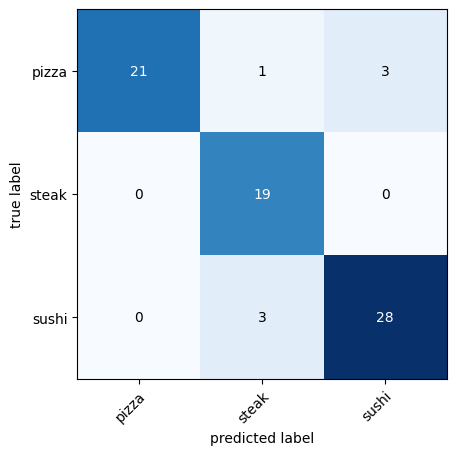

In [14]:
from mlxtend.plotting import plot_confusion_matrix

confmat = torchmetrics.ConfusionMatrix(task="multiclass",
                             num_classes=len(class_names))
confmat_tensor = confmat(predction_tensor, targets_tensor)

plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


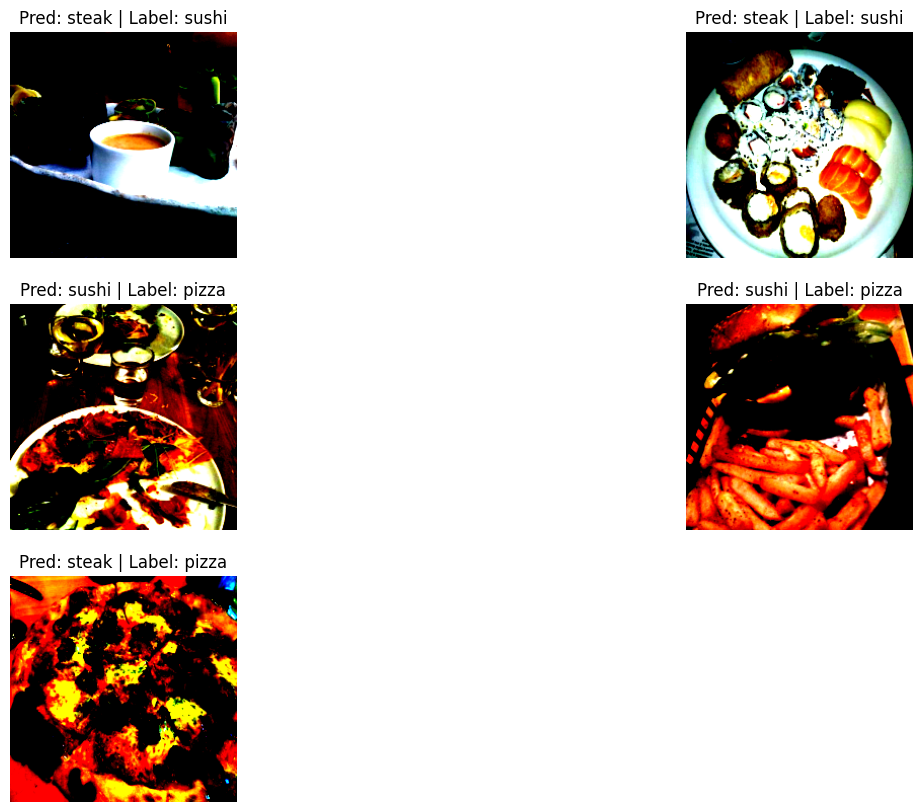

In [15]:
import pandas as pd

df = pd.DataFrame({"label":targets_tensor, "pred":predction_tensor, "prob":probs_tensor})
df_wrong = df[df['label'] != df['pred']]
df_wrong_desc_prob = df_wrong.sort_values(by=['prob'], ascending=False)

plt.figure(figsize=(16, 10))
for a, i in enumerate(df_wrong_desc_prob.head().index):
    plt.subplot(3, 2, a+1)
    plt.imshow(test_dataloader.dataset[i][0].permute(1, 2, 0))
    plt.title(f"Pred: {class_names[df_wrong_desc_prob['pred'][i]]} | Label: {class_names[df_wrong_desc_prob['label'][i]]}")
    plt.axis(False)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

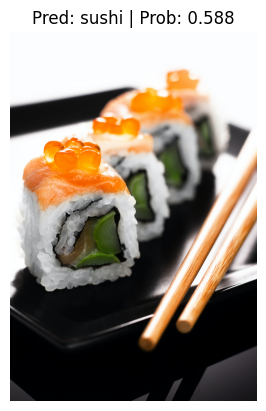

In [25]:
# TODO: Get an image of pizza/steak/sushi
from going_modular.going_modular import predictions

image_path = Path("./s.jpg")

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

predictions.pred_and_plot_image(model=model_0,
                                class_names=class_names,
                                image_path=str(image_path),
                                transform=data_transforms,
                                device=device)

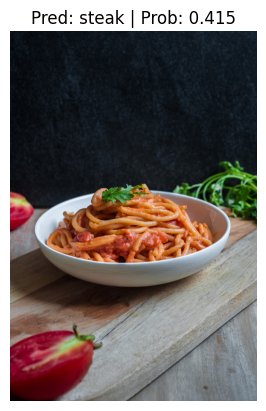

In [21]:
# TODO: Get an image of not pizza/steak/sushi

image_path = Path("./pasta.jpg")

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

predictions.pred_and_plot_image(model=model_0,
                                class_names=class_names,
                                image_path=str(image_path),
                                transform=data_transforms,
                                device=device)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [26]:
# TODO: Recreate a new model 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model.parameters():
    param.requires_grad=False

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model_results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0345 | train_acc: 0.4375 | test_loss: 0.8748 | test_acc: 0.6420
Epoch: 2 | train_loss: 0.9220 | train_acc: 0.6602 | test_loss: 0.6734 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.7480 | train_acc: 0.8516 | test_loss: 0.6546 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.7006 | train_acc: 0.7344 | test_loss: 0.6524 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.6769 | train_acc: 0.7578 | test_loss: 0.6131 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.5934 | train_acc: 0.7656 | test_loss: 0.5059 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5432 | train_acc: 0.7695 | test_loss: 0.4720 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.5150 | train_acc: 0.8945 | test_loss: 0.4674 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.5463 | train_acc: 0.8203 | test_loss: 0.5088 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.4596 | train_acc: 0.9219 | test_loss: 0.5000 | test_acc: 0.8873


In [ ]:
# TODO: Train the model for 10 epochs

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [27]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [28]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [29]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x27fb1062830>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [30]:
# TODO
torch.manual_seed(42)
torch.cuda.manual_seed(42)

weights_2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights_2).to(device)

for param in model_2.parameters():
    param.requires_grad=False

model_2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

model_2_results = engine.train(model=model_2,
                               train_dataloader=train_dataloader_20_percent,
                               test_dataloader=test_dataloader_20_percent,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9429 | train_acc: 0.5917 | test_loss: 0.6703 | test_acc: 0.8824
Epoch: 2 | train_loss: 0.7025 | train_acc: 0.8083 | test_loss: 0.5291 | test_acc: 0.8915
Epoch: 3 | train_loss: 0.5829 | train_acc: 0.8333 | test_loss: 0.4595 | test_acc: 0.8886
Epoch: 4 | train_loss: 0.4979 | train_acc: 0.8625 | test_loss: 0.3985 | test_acc: 0.9313
Epoch: 5 | train_loss: 0.4739 | train_acc: 0.8250 | test_loss: 0.3752 | test_acc: 0.9131
Epoch: 6 | train_loss: 0.4086 | train_acc: 0.8896 | test_loss: 0.3528 | test_acc: 0.9318
Epoch: 7 | train_loss: 0.4575 | train_acc: 0.8417 | test_loss: 0.3392 | test_acc: 0.9313
Epoch: 8 | train_loss: 0.3294 | train_acc: 0.9000 | test_loss: 0.3431 | test_acc: 0.8920
Epoch: 9 | train_loss: 0.3461 | train_acc: 0.8917 | test_loss: 0.2840 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.3118 | train_acc: 0.9083 | test_loss: 0.2803 | test_acc: 0.9193


### Train a model with 20% of the data

In [ ]:
# TODO

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [39]:
# TODO
torch.manual_seed(42)
torch.cuda.manual_seed(42)

weights_vit = torchvision.models.ViT_B_16_Weights.DEFAULT
auto_transform = weights_vit.transforms()

model_vit = torchvision.models.vit_b_16(weights_vit).to(device)

for param in model_vit.parameters():
    param.requires_grad=False

model_vit.heads = nn.Sequential(
    nn.Linear(in_features=768,
              out_features=len(class_names),
              bias=True)
).to(device)

# summary(model_vit, (32, 3, 224, 224),verbose=0, col_names=["input_size", "output_size", "trainable"], col_width=20, row_settings=["var_names"])

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                              test_dir=test_dir_20_percent,
                              transform=auto_transform,
                              batch_size=32,)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_vit.parameters(), lr=0.001)

model_vit_results = engine.train(
    model=model_vit,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5556 | train_acc: 0.8438 | test_loss: 0.2177 | test_acc: 0.9688
Epoch: 2 | train_loss: 0.2022 | train_acc: 0.9563 | test_loss: 0.1156 | test_acc: 0.9938
Epoch: 3 | train_loss: 0.1439 | train_acc: 0.9625 | test_loss: 0.0870 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1191 | train_acc: 0.9708 | test_loss: 0.0763 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.1261 | train_acc: 0.9771 | test_loss: 0.0682 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.0845 | train_acc: 0.9833 | test_loss: 0.0641 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0727 | train_acc: 0.9833 | test_loss: 0.0606 | test_acc: 0.9875
Epoch: 8 | train_loss: 0.0655 | train_acc: 0.9854 | test_loss: 0.0595 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0568 | train_acc: 0.9875 | test_loss: 0.0560 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0521 | train_acc: 0.9938 | test_loss: 0.0546 | test_acc: 0.9875


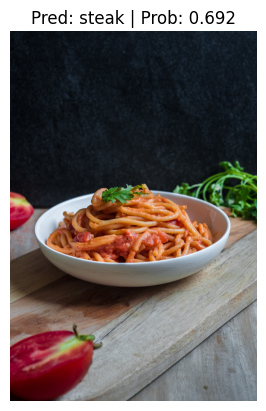

In [51]:
# TODO: Get an image of pizza/steak/sushi
from going_modular.going_modular import predictions

image_path = Path("./pasta.jpg")

predictions.pred_and_plot_image(model=model_vit,
                                class_names=class_names,
                                image_path=str(image_path),
                                transform=auto_transform,
                                device=device)

In [41]:
# TODO
predictions = []
targets = []
probs = []

model_vit.eval()
with torch.inference_mode():
    for X, y in test_dataloader_vit:
        X, y = X.to(device), y.to(device)

        pred = model_vit(X)
        pred_label = torch.argmax(torch.softmax(pred, dim=1), dim=1)

        predictions.append(pred_label.detach().cpu())
        targets.append(y.detach().cpu())
        probs.append(torch.softmax(pred, dim=1).max(dim=1).values)

predction_tensor = torch.cat(predictions)
targets_tensor = torch.cat(targets)
probs_tensor = torch.cat(probs).cpu()
predction_tensor, targets_tensor, probs_tensor

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

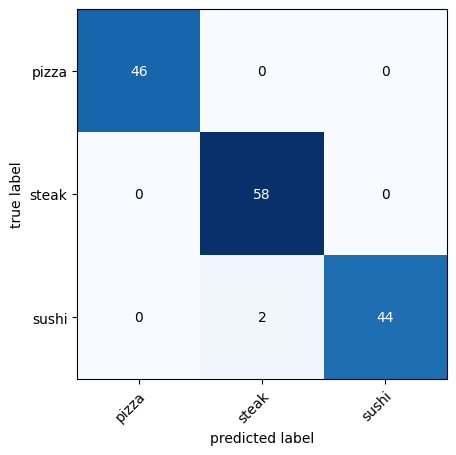

In [42]:
from mlxtend.plotting import plot_confusion_matrix

confmat = torchmetrics.ConfusionMatrix(task="multiclass",
                             num_classes=len(class_names))
confmat_tensor = confmat(predction_tensor, targets_tensor)

plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names)

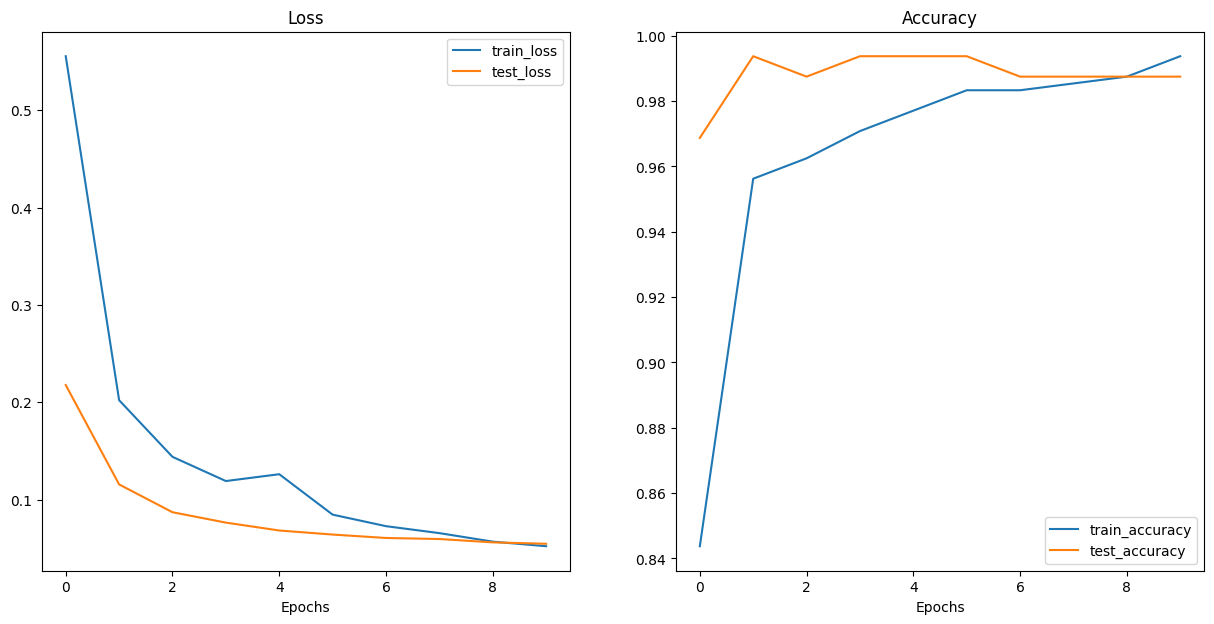

In [43]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_vit_results)

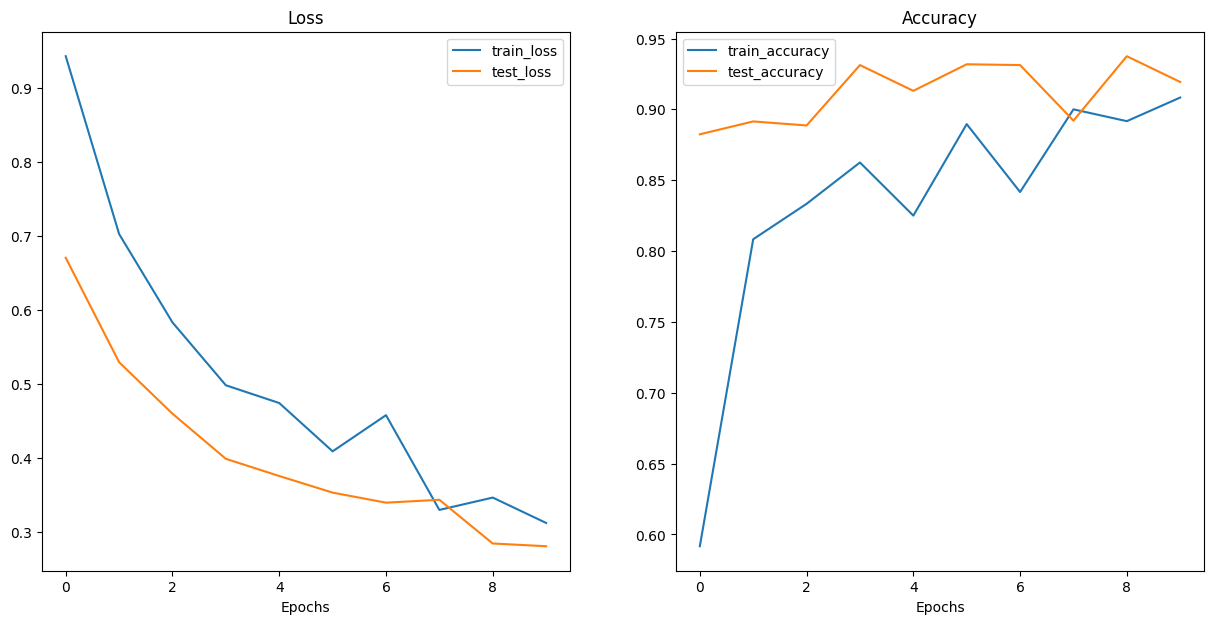

In [44]:
plot_loss_curves(model_2_results)

In [45]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trianed model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image(model requires samples in [batch_size, colour_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

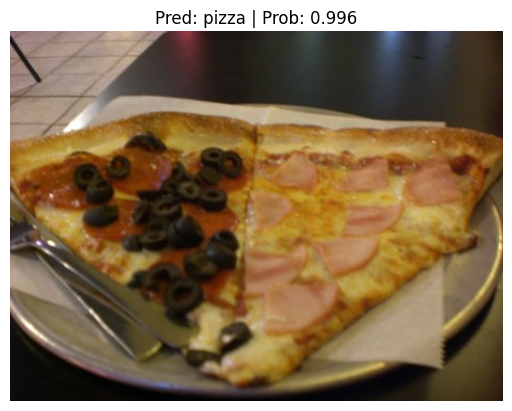

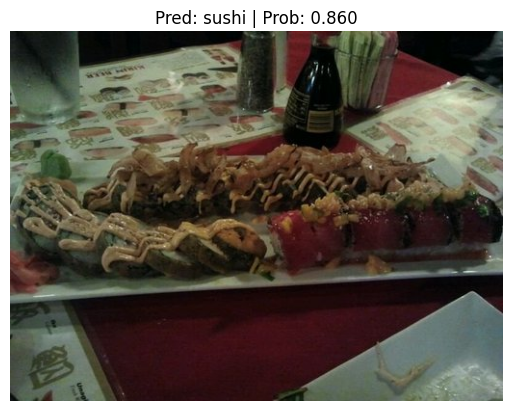

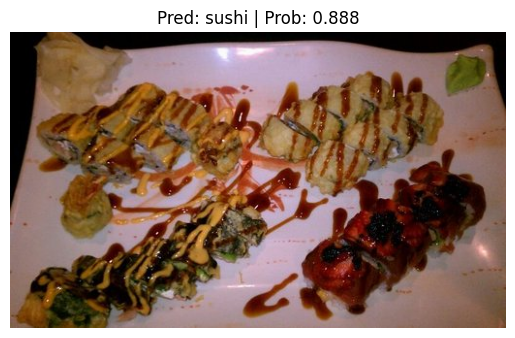

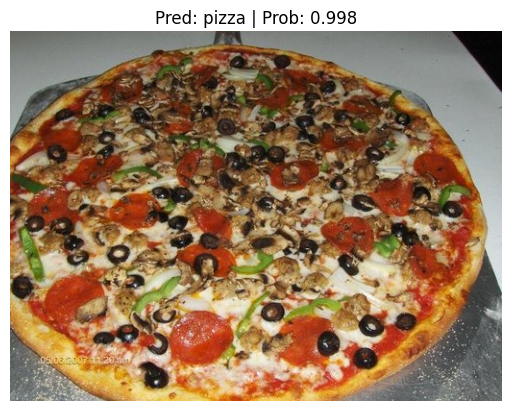

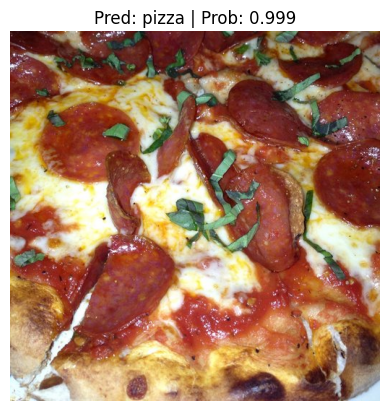

In [48]:
# Get a random list of image paths from test set
import random

num_images_to_plot = 5
test_images_path_list = list(Path(test_dir_20_percent).glob("*/*.jpg")) # get list all image paths from test data
test_images_path_sample = random.sample(population=test_images_path_list, # go through all of the test image paths
                                        k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predicitons on and plot the images
for image_path in test_images_path_sample:
    pred_and_plot_image(model=model_vit,
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights_vit.transforms(),
                        image_size=(224, 224))

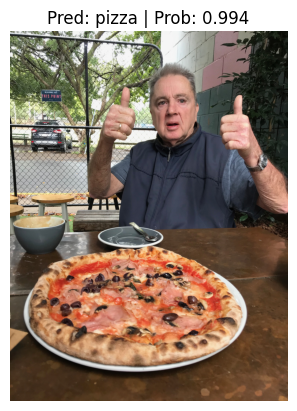

In [50]:
pred_and_plot_image(model=model_vit,
                    image_path= data_path / "04-pizza-dad.jpeg",
                    class_names=class_names)